In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import fiona
import collections
import matplotlib.pyplot as plt
import pyproj
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio import features
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date, timedelta
import geopandas
import os
from shapely import geometry
import numpy as np
import utilities
import pandas as pd
import shutil
import glob
pd.set_option('display.max_columns', None)
import time
import zipfile
import geopandas as gpd
import shapely
import geopandas as gpd
from shapely.geometry import MultiPoint, Polygon
from PIL import Image

In [3]:
# 18-21 Jul 2019
start_date = date.today() - timedelta(15)
end_date = date.today()

In [4]:
path = "/home/primity/terras/bulk/"
dest = "/home/primity/terras/bulk_crops/"

In [147]:
freguesias_shapes=gpd.read_file("gadm36_PRT_shp/gadm36_PRT_3.shp")
concelhos_shapes = gpd.read_file("gadm36_PRT_shp/gadm36_PRT_2.shp")
cardigos_shp = freguesias_shapes[freguesias_shapes.NAME_3=='Cardigos'].iloc[0].geometry
macao_shp = concelhos_shapes[concelhos_shapes.NAME_2=='Mação'].iloc[0].geometry

In [148]:
macao_outer_square = utilities.polygon_outer_square(macao_shp)

In [149]:
concelhos_shapes_ptcrs = concelhos_shapes.to_crs(epsg=32629)
macao_shp_ptcrs = concelhos_shapes_ptcrs[concelhos_shapes_ptcrs.NAME_2=='Mação'].iloc[0].geometry

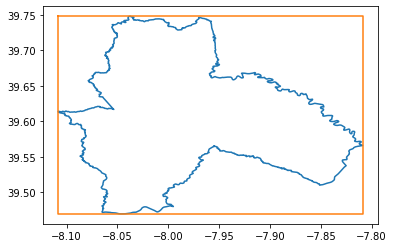

In [150]:
plt.plot(*macao_shp.exterior.xy)
plt.plot(*macao_outer_square.exterior.xy)

In [151]:
api = SentinelAPI('fernandeslouro', 'copernicospw', 'https://scihub.copernicus.eu/dhus')
products = api.query(macao_outer_square,
                     date=(date.today() - timedelta(7), date.today()),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 30))
products_df = api.to_dataframe(products)
products_df['footprint'] = geopandas.GeoSeries.from_wkt(products_df['footprint'])
products_df = gpd.GeoDataFrame(products_df, geometry='footprint')
products_df['fully_contained'] = products_df.apply(lambda row: row.footprint.contains(macao_shp), axis=1)
products_df['intersection_area'] = products_df.apply(lambda row: macao_shp.intersection(row.footprint).area/macao_shp.area, axis=1)

In [152]:
products_df = products_df[products_df['intersection_area']>0.95]

In [153]:
products_df.head(4)

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,illuminationazimuthangle,illuminationzenithangle,vegetationpercentage,notvegetatedpercentage,waterpercentage,unclassifiedpercentage,mediumprobacloudspercentage,highprobacloudspercentage,snowicepercentage,cloudcoverpercentage,level1cpdiidentifier,gmlfootprint,footprint,format,processingbaseline,platformname,filename,instrumentname,instrumentshortname,size,s2datatakeid,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,datatakesensingstart,sensoroperationalmode,tileid,hv_order_tileid,fully_contained,intersection_area
0cffc8ec-55f2-4a82-99ae-02e72a046608,S2A_MSIL2A_20210603T112111_N0300_R037_T29SND_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-06-03T11:21:11.024Z, Instrument: MS...",false,2021-06-03 14:42:54,2021-06-03 11:21:11.024,2021-06-03 11:21:11.024,2021-06-03 18:12:15.388,31065,37,137.892773,21.320668,49.537754,24.710512,0.645841,0.583777,0.542298,0.417753,0.00002,23.846718,S2A_OPER_MSI_L1C_TL_VGS2_20210603T133740_A0310...,"<gml:Polygon srsName=""http://www.opengis.net/g...","MULTIPOLYGON (((-7.73660 38.75404, -7.71872 39...",SAFE,03.00,Sentinel-2,S2A_MSIL2A_20210603T112111_N0300_R037_T29SND_2...,Multi-Spectral Instrument,MSI,1.10 GB,GS2A_20210603T112111_031065_N03.00,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20210603T144254_S2021...,S2A_OPER_MSI_L2A_TL_VGS2_20210603T144254_A0310...,S2A_MSIL2A_20210603T112111_N0300_R037_T29SND_2...,0cffc8ec-55f2-4a82-99ae-02e72a046608,NaT,NaN,NaN,NaN,False,0.999616


In [154]:
len(products_df)

1

0.9996164580250373


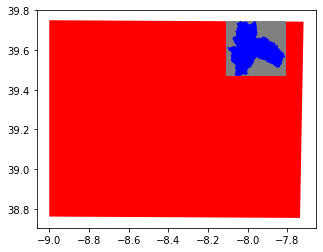

In [155]:
for polygon1 in list(products_df.footprint):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    gpd.GeoSeries(polygon1).plot(ax=ax, color='red')
    gpd.GeoSeries(macao_outer_square).plot(ax=ax, color='grey')
    gpd.GeoSeries(macao_shp).plot(ax=ax, color='blue')
    print(macao_shp.intersection(polygon1).area/macao_shp.area)
    plt.show()

In [84]:
os.makedirs(path, exist_ok=True)
os.makedirs(dest, exist_ok=True)

#get products list from this day
api = SentinelAPI('fernandeslouro', 'copernicospw', 'https://scihub.copernicus.eu/dhus')
products = api.query(macao_outer_square,
                     date=(date.today() - timedelta(7), date.today()),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 30))
products_df = api.to_dataframe(products)

if products_df.empty:
    print('No images found')
else:    
    downloaded_product = utilities.download_most_recent_product(products_df, polygon_to_overlap=macao_shp, path=path)


11 available products
Trying to download 0cffc8ec-55f2-4a82-99ae-02e72a046608


Downloading: 100%|██████████| 1.19G/1.19G [07:44<00:00, 2.55MB/s]
MD5 checksumming: 100%|██████████| 1.19G/1.19G [00:01<00:00, 811MB/s]


In [85]:
# copy jp2 to dest
utilities.subfolders_copy(os.path.join(path, downloaded_product['title'] + '.SAFE'), dest)

In [162]:
out_image

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [192]:
mask = numpy.full((out_image.shape[1], out_image.shape[2]), True, dtype=bool)
for band in range(out_image.shape[0]):
    mask *= out_image[band]==0
mask = 1 * mask
mask = mask.reshape((1, mask.shape[0], mask.shape[1]))

In [212]:
unique, counts = np.unique(mask, return_counts=True)
dict(zip(unique, counts))

{0: 3915444, 1: 4006254}

In [211]:
print(out_image.shape, mask.shape, type(out_image), type(mask))

(4, 3074, 2577) (3074, 2577) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [196]:
transp = np.append(out_image, mask, axis=0)

In [202]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [217]:
mask = numpy.full((out_image.shape[1], out_image.shape[2]), True, dtype=bool)
for band in range(out_image.shape[0]):
    mask *= out_image[band]==0
mask = 1 * mask
#mask = mask.reshape((1, mask.shape[0], mask.shape[1]))
mask = 1-mask
#out_image=np.append(out_image, mask, axis=0)

In [214]:
mask.shape

(3074, 2577)

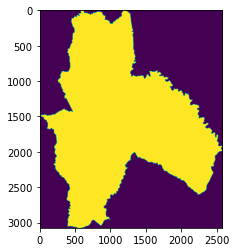

In [218]:
plt.imshow(mask)
plt.show()

In [220]:
out_image.shape

(4, 3074, 2577)

In [232]:
# save cropped jp2 with same name 
for i in utilities.listdir_nohidden(dest):
    with rasterio.open(os.path.join(dest, i)) as src:
        out_image, out_transform = rasterio.mask.mask(src, [macao_shp_ptcrs], crop=True, nodata=0, all_touched=True)
        out_meta = src.meta.copy() 
    
    mask = numpy.full((out_image.shape[1], out_image.shape[2]), True, dtype=bool)
    for band in range(out_image.shape[0]):
        mask *= out_image[band]==0
    mask = 255 * mask
    mask = mask.reshape((1, mask.shape[0], mask.shape[1]))
    mask = 255-mask
    out_image=np.append(out_image, mask, axis=0)
            
    with rasterio.open(os.path.join(dest, i)[:-4]+'.png','w',
                       driver='PNG',
                       height=out_image.shape[1],
                       width=out_image.shape[2],
                       dtype=rasterio.uint8,
                       count=out_image.shape[0],
                       compress='lzw') as dst:
        dst.write(np.array(out_image, dtype='uint8'))
    print(type(out_image), out_image.shape)
    print(out_image)
    
    im=Image.fromarray(out_image)
    im.save("bulk_crops/your_file.png")
#for f in utilities.listdir_nohidden(dest):
#    if '.jp2' in f and not f.startswith('.'):
#        os.remove(os.path.join(dest, f))

#for f in glob.glob(os.path.join(path, to_download['title'])):
#    os.remove(f)
 

<class 'numpy.ndarray'> (3, 3074, 2577)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


TypeError: Cannot handle this data type: (1, 1, 2577), |u1

In [112]:
im=Image.fromarray(out_image)
im.save("your_file.png")

NameError: name 'out_image' is not defined

In [ ]:
plt.figure(figsize=(20,20))
plt.title(f'{np.array(out_image).shape} - {i}')
#plt.save(i)
out_image = (out_image-out_image.min())/(out_image.max()-out_image.min())
show(out_image)

In [132]:
from PIL import Image
im = Image.open('bulk_crops/T29SND_20210603T112111_TCI_10m.jp2')

In [133]:
im

ValueError: Could not save to PNG for display

<PIL.Jpeg2KImagePlugin.Jpeg2KImageFile image mode=RGB size=10980x10980 at 0x7FAAC1A9D160>

In [130]:
import rasterio

ds = rasterio.open('bulk_crops/T29SND_20210603T112111_TCI_10m.jp2')
ay=ds.read(1)

In [131]:
ay

array([[ 71,  59,  60, ...,  91,  87,  98],
       [ 78,  74,  73, ...,  93,  85,  89],
       [ 75,  78,  72, ..., 100,  94,  91],
       ...,
       [103, 105, 105, ...,  91,  74,  87],
       [102, 104, 104, ..., 137, 121, 100],
       [104, 104, 103, ..., 112, 125,  98]], dtype=uint8)

In [127]:
im=Image.fromarray(im)

OSError: decoder jpeg2k not available